# Processing example notebook

Example notebook showing the base post-processing functionality for an example dataset.

In this example, we will use the binned files from the **2021 Fram Strait cruise**. These files are located in the folder `cnv_input`.

##### Structure:

-  Load the data
-  Finally, we will export the file to netcdf as well as `.mat` and `.csv`.

### Initial imports

Import the `oceanograpy.data.ctd` module which is 

We also import some other stuff that is useful for plotting, etc, and enable interactive plotting in the notebook. 

In [1]:
from oceanograpy.data import ctd
%matplotlib widget

In [2]:
from oceanograpy.io import sbe
from oceanograpy.data.ship_ctd_tools import _ctd_tools as tools
import importlib as imp
import glob2

In [3]:
imp.reload(tools)
imp.reload(sbe)
imp.reload(ctd)

<module 'oceanograpy.data.ctd' from '/home/oyvindl/work/code/python/oceanograPy/src/oceanograpy/data/ctd.py'>

### 1. Load the data

- Loading `.cnv` files
- Structuring into an object `D`, containing all data variables from the file and with all the metadata we were able to retrieve.
    -  From here, we will modify `D` until we are happy with the data and metadata.


In [5]:
D = ctd.ctds_from_cnv_dir('cnv_files')

Found 22 .cnv files in  "cnv_files".
Loaded 22 profiles from list of Datasets.
NOTE: It seems the input data already binned -> using preexisting binning.


Joining profiles together:   0%|          | 0/22 [00:00<?, ?it/s]

##### 1.1 Inspect the loaded data

We have now hopefully loaded the files into the object `D` and put them together into one files with associated metadata.

`D` is an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html). This data type integrates well with netCDF and, very usefully, with Jupyter notebooks. We can at any time execute `D` in a code cell, allowing us to inspect the whole object with data and metadata. 

In this case, we have just loaded everything from the files, so the data file is not ready for export. But we can look at what was loaded, and check that the data and metadata look sensible. 

-> Run the cell and click around to look at:

- Metadata (document symbols and the right)
- Data (database symbols on the right)

*Note:* By default, sensors names have a numeric e.g., `TEMP1`. This is useful in case we have duplicate sensors. Later, we will drop the numbers if we only retain one sensor.

A nice sanity check is to plot the stations on a map:

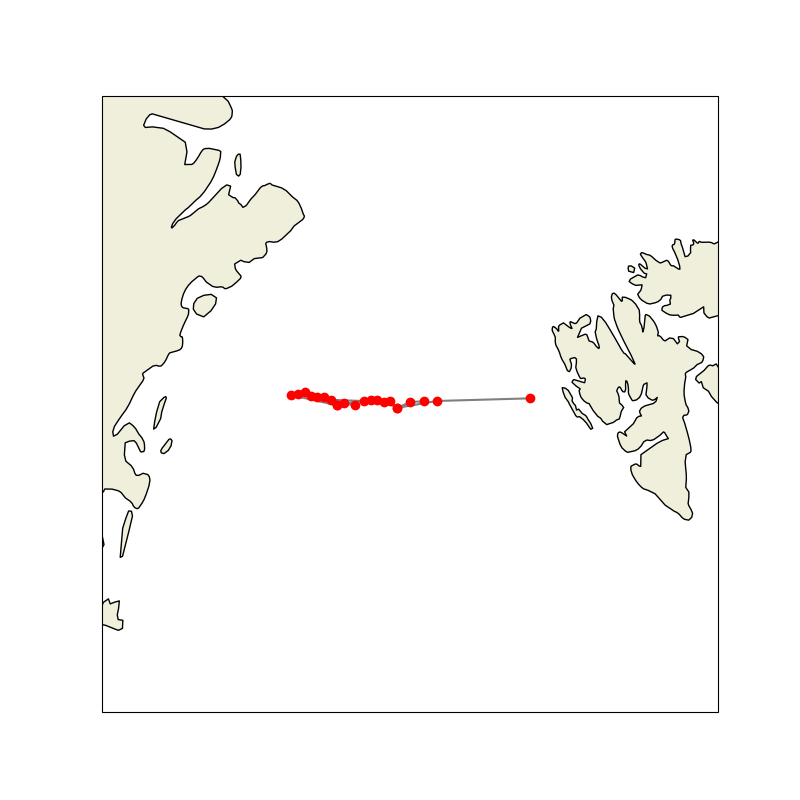

In [78]:
ctd.map(D)

### Looking ahead: Nicely formatting metadata and getting rid of unwanted fields

At this point, it may be useful to clean things up a bit. We will get rid of variables that we are not interested in, and we want to add some standard metadata.

Several functions which do basically this are included in the wrapper function `ctd.make_publishing_ready`. Let's see what happens when we apply it to this dataset:

In [79]:
D_nice = ctd.make_publishing_ready(D, NPI=True,)

Dropped these variables from the Dataset: ['TEMP2', 'CNDC2', 'DOXY1_instr', 'CDOM1_instr', 'CDOM2_instr', 'LATITUDE_SAMPLE', 'LONGITUDE_SAMPLE', 'PSAL2', 'SBE_FLAG', 'TIME_SAMPLE'].


In [80]:
D_nice

<xarray.Dataset>
Dimensions:    (PRES: 2703, TIME: 22)
Coordinates:
  * PRES       (PRES) float64 2.0 3.0 4.0 5.0 ... 2.702e+03 2.703e+03 2.704e+03
  * TIME       (TIME) float64 1.925e+04 1.925e+04 ... 1.925e+04 1.925e+04
Data variables:
    TEMP       (TIME, PRES) float64 nan 2.444 3.183 3.33 ... nan nan nan nan
    CNDC       (TIME, PRES) float64 nan 2.957 3.054 3.071 ... nan nan nan nan
    PSAL       (TIME, PRES) float64 nan 33.02 33.44 33.49 ... nan nan nan nan
    STATION    (TIME) <U4 ' 001' ' 002' ' 003' ' 004' ... ' 020' ' 021' ' 022'
    LATITUDE   (TIME) float64 78.92 78.92 78.83 78.91 ... 78.83 78.92 78.83
    LONGITUDE  (TIME) float64 0.0252 -0.9887 -1.954 -2.99 ... -1.952 1.003 8.0
    CRUISE     <U7 'FS 2022'
Attributes: (12/46)
    history:                         2022-09-10 to 2022-09-18: Data collectio...
    cruise_name:                     FS 2022
    institution:                     Norwegian Polar Institute (NPI)
    source:                          CTD profiles from SBE911+
    instrument:                      In Situ/Laboratory Instruments>Profilers...
    data_set_language:               eng
    ...                              ...
    instrument_vocabulary:           NASA/GCMD Instrument Keywords Version 17.2
    keywords_vocabulary:             NASA/GCMD Science Keywords 9.1.5
    iso_topic_category:              oceans
    Conventions:                     ACDD-1.3, CF-1.8
    naming_authority:                npolar.no
    ship:                            Silver Arctic

___
Note: If we wanted to retain a different set of variables, we could do:

`ctd.make_publishing_ready(D, NPI=True, retain_vars=['TEMP1', 'CNDC1', 'PSAL1', 'CHLA1', 'PRES', 'CDOM1_instr',])`

We could also specify `retain_all`, or give a list of which ones to drop (e.g. `drop_vars=['PSAL2', 'CDOM2_instr']`)

___

If we now look `D_nice`, we should see that we have lost a bunch of variables, and that both global and variable attributes have been added or updated. Any metadata fields can be changed later on, but this can serve as a useful starting point.

In [67]:
D_nice

<xarray.Dataset>
Dimensions:    (PRES: 2703, TIME: 22)
Coordinates:
  * PRES       (PRES) float64 2.0 3.0 4.0 5.0 ... 2.702e+03 2.703e+03 2.704e+03
  * TIME       (TIME) float64 1.925e+04 1.925e+04 ... 1.925e+04 1.925e+04
Data variables:
    STATION    (TIME) <U4 ' 001' ' 002' ' 003' ' 004' ... ' 020' ' 021' ' 022'
    LATITUDE   (TIME) float64 78.92 78.92 78.83 78.91 ... 78.83 78.92 78.83
    LONGITUDE  (TIME) float64 0.0252 -0.9887 -1.954 -2.99 ... -1.952 1.003 8.0
    CRUISE     <U7 'FS 2022'
Attributes: (12/46)
    history:                         2022-09-10 to 2022-09-18: Data collectio...
    cruise_name:                     FS 2022
    institution:                     Norwegian Polar Institute (NPI)
    source:                          CTD profiles from SBE911+
    instrument:                      In Situ/Laboratory Instruments>Profilers...
    data_set_language:               eng
    ...                              ...
    instrument_vocabulary:           NASA/GCMD Instrument Keywords Version 17.2
    keywords_vocabulary:             NASA/GCMD Science Keywords 9.1.5
    iso_topic_category:              oceans
    Conventions:                     ACDD-1.3, CF-1.8
    naming_authority:                npolar.no
    ship:                            Silver Arctic

### Processing steps

#### Visualizations

#### Manual outlier editing

#### Threshold editing

#### Calibrating chlorophyll

In [ ]:
ctd.calibrate_chl()

### Metadata overhaul

We will now run the metadata function from above

In [69]:
D = ctd.make_publishing_ready(D, NPI=True, retain_vars=['TEMP1', 'CNDC1', 'PSAL1', 'CHLA1', 'PRES', 'CDOM1_instr',])

Dropped these variables from the Dataset: ['TEMP', 'CNDC', 'PSAL'].


##### Checking the metadata

In [73]:
ctd.check_conventions.check_file(D)



--------------------------------------------------------------------------------
                         IOOS Compliance Checker Report                         
                                 Version 5.1.0                                  
                     Report generated 2023-12-04T16:22:31Z                      
                                    acdd:1.3                                    
http://wiki.esipfed.org/index.php?title=Category:Attribute_Conventions_Dataset_Discovery
--------------------------------------------------------------------------------
                               Corrective Actions                               
temp.nc has 3 potential issues


                               Highly Recommended                               
--------------------------------------------------------------------------------
Global Attributes
* keywords is empty or completely whitespace
* summary not present
* title not present


                                  Recomm

Using cached standard name table v83 from /home/oyvindl/.local/share/compliance-checker/cf-standard-name-table-test-83.xml


In [81]:
from oceanograpy.data.nc_format import conventionalize

In [84]:
D = conventionalize.set_glob_attr(D, 'processing_level')

In [85]:
D

<xarray.Dataset>
Dimensions:           (PRES: 2703, TIME: 22)
Coordinates:
  * PRES              (PRES) float64 2.0 3.0 4.0 ... 2.703e+03 2.704e+03
  * TIME              (TIME) float64 1.925e+04 1.925e+04 ... 1.925e+04 1.925e+04
Data variables: (12/17)
    TEMP1             (TIME, PRES) float64 nan 2.444 3.183 3.33 ... nan nan nan
    TEMP2             (TIME, PRES) float64 nan 2.757 3.202 3.334 ... nan nan nan
    CNDC1             (TIME, PRES) float64 nan 2.957 3.054 3.071 ... nan nan nan
    CNDC2             (TIME, PRES) float64 nan 2.999 3.057 3.071 ... nan nan nan
    DOXY1_instr       (TIME, PRES) float64 nan 376.9 363.5 362.7 ... nan nan nan
    CDOM1_instr       (TIME, PRES) float64 nan 0.1319 0.135 ... nan nan nan
    ...                ...
    SBE_FLAG          (TIME, PRES) float64 nan 0.0 0.0 0.0 ... nan nan nan nan
    TIME_SAMPLE       (TIME, PRES) float64 nan 1.925e+04 1.925e+04 ... nan nan
    STATION           (TIME) <U4 ' 001' ' 002' ' 003' ... ' 020' ' 021' ' 022'
    LATITUDE          (TIME) float64 78.92 78.92 78.83 ... 78.83 78.92 78.83
    LONGITUDE         (TIME) float64 0.0252 -0.9887 -1.954 ... -1.952 1.003 8.0
    CRUISE            <U7 'FS 2022'
Attributes:
    binned:          1 decibars (SBE software)
    history:         2022-09-10 to 2022-09-18: Data collection.\n2022-09-13 t...
    ship:            Silver Arctic
    cruise_name:     FS 2022
    latitude:        78.9532
    longitude:       -9.0077
    SBE_processing:  SBE SOFTWARE PROCESSING STEPS (extracted from .cnv file ...
    source_files:    E.g. 006.HEX, FS2022_CTD.XMLCON -> 006_BIN.CNV
    featureType:     profile
    acknowledgment:  Hello this is an acknowledgment.

In [ ]:
### Dealing with missing metadata

We should  